# Black Friday Sales Prediction

Team Members:
    
    - Arun Reddy Nalla
    - Darun Arumugham
    - Siddhartha Pitchika
    - Varshitha Seralathan

![Black Friday Sales](https://www.shopivo.com/blog/wp-content/uploads/2019/11/Black-Friday-Sales-Plan-Header.png)

## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from pywaffle import Waffle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## MongoDB Connectivity

In [3]:
from pymongo import MongoClient
client = MongoClient("localhost", 27017) 
db = client.ADTProject
train_collection = db.Train
test_collection = db.Test

In [4]:
train= pd.DataFrame(list(train_collection.find()))
train.drop('_id', inplace=True, axis=1)
test= pd.DataFrame(list(test_collection.find()))
test.drop('_id', inplace=True, axis=1)

### Data Exploration

In [5]:
train.head(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase,Product_Category_2,Product_Category_3
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370,NaN,NaN
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200,6.0,14.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422,NaN,NaN
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057,14.0,NaN
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969,NaN,NaN


This dataset represents a sample of the retail store transactions. The retailer wants to understand better how customers choose between various products.


- Understanding the cutomers on the basis of their purchasing habits.
- Understanding the purchasing habits according to Age groups, Occuptation, City_Categories.
- Segmented group of users can be then used to model the data and use to predict the purchase spend for each customer.

In [6]:
# Information of the training dataset
print('Training data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print('Testing data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

Training data has 550068 rows and 12 columns
Testing data has 233599 rows and 11 columns


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Purchase                    550068 non-null  int64  
 10  Product_Category_2          376430 non-null  float64
 11  Product_Category_3          166821 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [8]:
train.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Purchase                      18105
Product_Category_2               17
Product_Category_3               15
dtype: int64

In [9]:
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Purchase,Product_Category_2,Product_Category_3
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9263.968713,9.842329,12.668243
std,1.727592e+03,6.522660,0.491770,3.936211,5023.065394,5.086590,4.125338
min,1.000001e+06,0.000000,0.000000,1.000000,12.000000,2.000000,3.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5823.000000,5.000000,9.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,8047.000000,9.000000,14.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,12054.000000,15.000000,16.000000
max,1.006040e+06,20.000000,1.000000,20.000000,23961.000000,18.000000,18.000000


Mean value of Product_Category_2 is 9.8 and that for Product_Category_3 is 12.6, which we will use to fill the missing values in these two columns.

In [10]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Purchase                           0
Product_Category_2            173638
Product_Category_3            383247
dtype: int64

In [11]:
#get total count of data including missing data
total = train.isnull().sum().sort_values(ascending=False)

#get percent of missing data relevant to all data
percent = (train.isnull().sum()*100/train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Product_Category_3,383247,69.672659
Product_Category_2,173638,31.566643
User_ID,0,0.000000
Product_ID,0,0.000000
Gender,0,0.000000
Age,0,0.000000
Occupation,0,0.000000
City_Category,0,0.000000
Stay_In_Current_City_Years,0,0.000000
Marital_Status,0,0.000000


There are 31% null values in the Product_Category_2 and 69% null values in the Product_Category_3

There might be some data inconsistency issues in both training and test dataset, data cleaning procedure is implememted in both the datasets by combining the data. 

In [12]:
#Imputing nan for Purchase column in test data
test['Purchase']=np.nan
train['Type of data']='Train'
test['Type of data']='Test'
test=test[train.columns]
data=pd.concat([train,test],axis=0)
data.shape

(783667, 13)

In [13]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase,Product_Category_2,Product_Category_3,Type of data
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370.0,NaN,NaN,Train
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200.0,6.0,14.0,Train
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422.0,NaN,NaN,Train
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057.0,14.0,NaN,Train
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969.0,NaN,NaN,Train


## Data Cleaning

The feature Product_Category_3 has 70% data missing so imputing this much data is not feasible , so it is better to drop this feature

In [14]:
data.drop('Product_Category_3',axis=1,inplace=True)

The feature Product_Category_2 has 30% data missing so we can impute values into this using an appromiate method.

In [15]:
#imputed missing values with random values in the same probability distribution as given feature already had

vc = data.Product_Category_2.value_counts(normalize = True)
miss = data.Product_Category_2.isna()
data.loc[miss, 'Product_Category_2'] = np.random.choice(vc.index, size = miss.sum(), p = vc.values)

In [16]:
data.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Purchase                      233599
Product_Category_2                 0
Type of data                       0
dtype: int64

There are no null values left in the data set.The purchase null values are because of the test data that needs to be predicted

## Exploratory Data Analysis

In [17]:
#using the train data part from combined dataset for eda

train = data[data['Type of data']=='Train']

### Gender

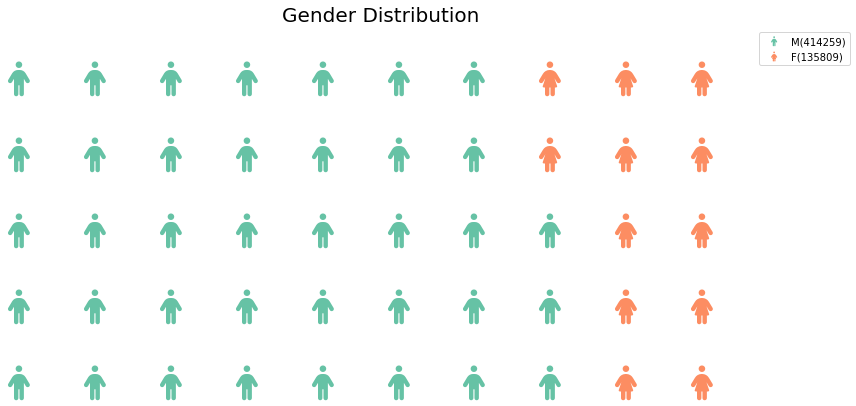

In [18]:
gender = train['Gender'].value_counts()

fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10,
    values=gender,
    title={'label': 'Gender Distribution', 'loc': 'center','size':20},
    labels=["{}({})".format(a, b) for a, b in zip(gender.index, gender) ],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1,1)},
    font_size=35, 
    icons = ['male','female'],
    icon_legend=True,
    figsize=(12, 8)
)


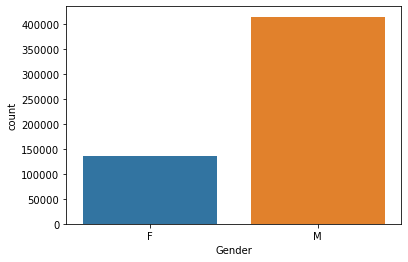

In [19]:
sns.countplot(train['Gender'])
plt.show()

Text(0.5, 1.0, 'Gender VS Purchase')

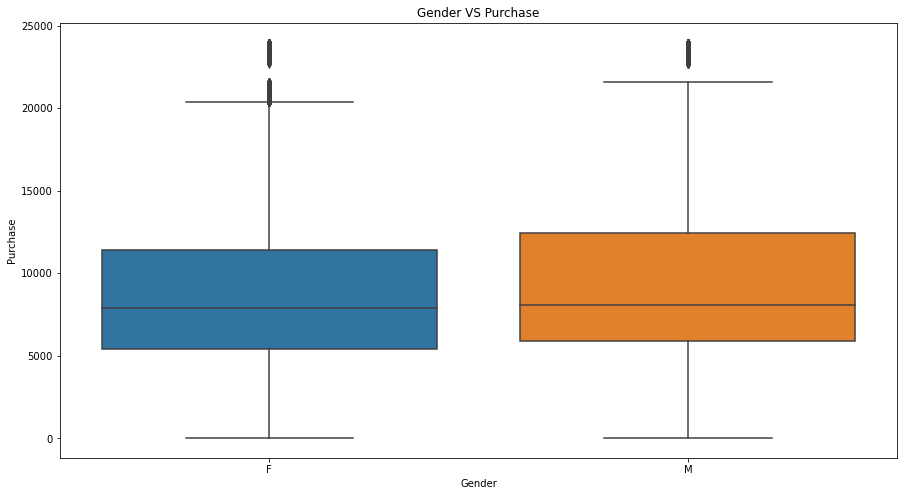

In [20]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Gender', y='Purchase', data=train)
plt.title('Gender VS Purchase')

Answer : Yes males buyers more than females buyers. Significantly.

Decision : We must take care of males than females in the next marketing campaigns. where the ratio is 75 to 25 percent respectively.

### Marital Status

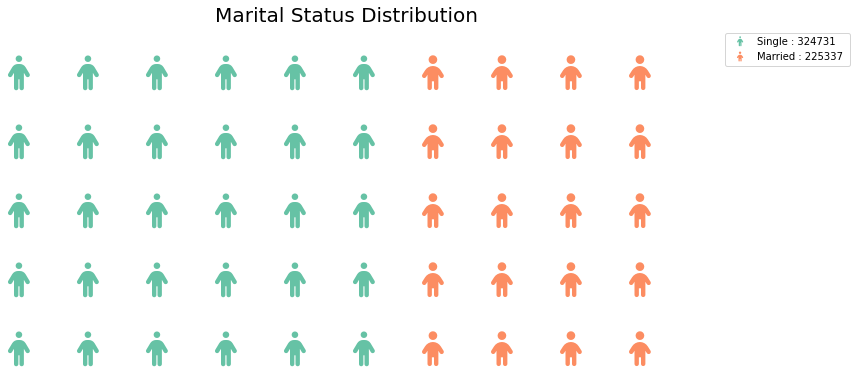

In [21]:
data1=("Single", "Married")
Marital_Status = train['Marital_Status'].value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10,
    values=Marital_Status,
    title={'label': 'Marital Status Distribution', 'loc': 'center','size':20},
    labels=["{} : {} ".format(a, b) for a, b in zip(data1, Marital_Status) ],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05,1)},
    font_size=35,
    icons = ['person','child'],
    icon_legend=True,
    figsize=(12, 8)
)

**Findings** : There are more unmarried customers in the dataset who purchase more during black friday sales

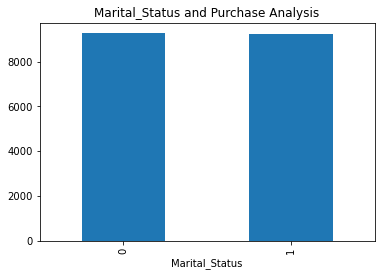

In [22]:
train.groupby("Marital_Status").mean()["Purchase"].plot(kind='bar')
plt.title("Marital_Status and Purchase Analysis")
plt.show()

**Findings** : Its evident that the average purchase amount for married and unmarried customers is the same, though unmarried customers purchase more.

### Purchase

<AxesSubplot:xlabel='Purchase', ylabel='Density'>

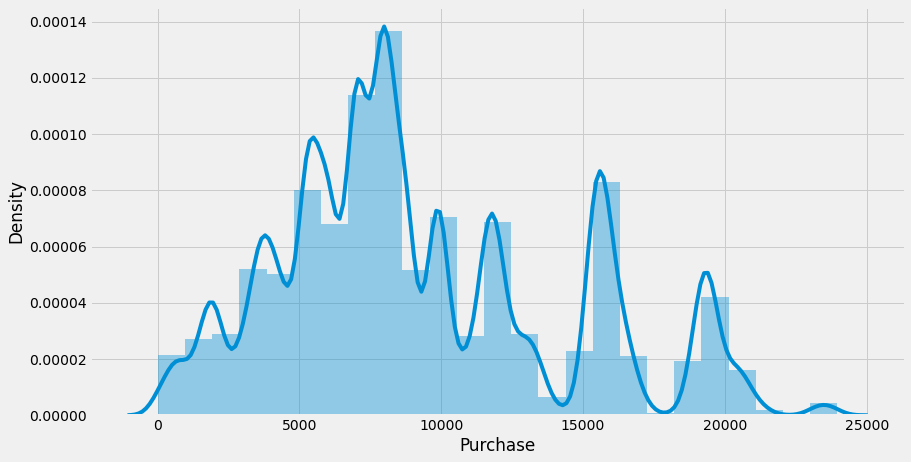

In [23]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(13, 7))
sns.distplot(train['Purchase'], bins=25 )

We can observe that purchase amount is repeating for many customers.This may be because on Black Friday many are buying discounted products in large numbers and kind of follows a Gaussian Distribution.

Text(0.5, 1.0, 'Purchase violinplot')

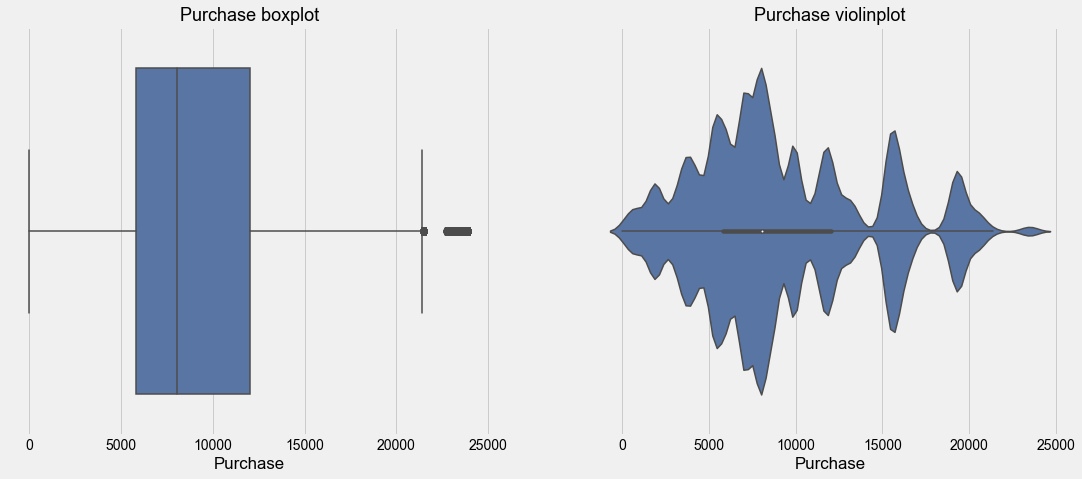

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[17,7])

sns.set(style="whitegrid")

sns.boxplot(x = train["Purchase"],ax=ax[0]).set_title("Purchase boxplot", fontsize=18)

sns.violinplot(train["Purchase"],ax=ax[1]).set_title("Purchase violinplot", fontsize=18)

### Occupation

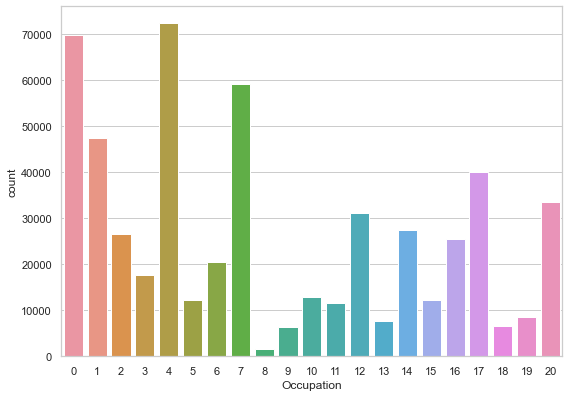

In [25]:
plt.figure(figsize=(8,6))
sns.countplot(x ='Occupation', data = train)
plt.show()

**Findings** : Occupation has at least 20 different values. Since we do not known to each occupation each number corresponds, is difficult to make any analysis.

Customers whose occupations are 0 and 4 have done more transactions during Black Friday sales

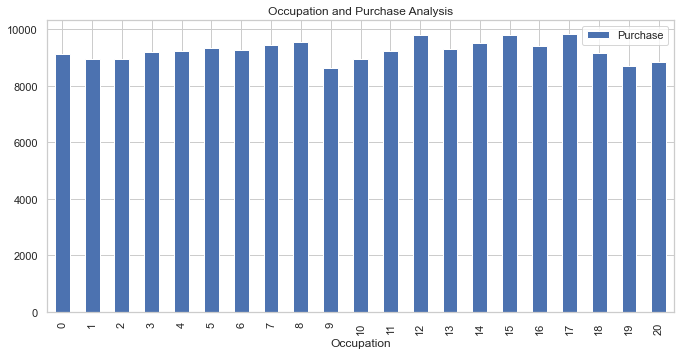

In [26]:
occup = pd.DataFrame(train.groupby("Occupation").mean()["Purchase"])
occup.plot(kind='bar',figsize=(10,5))
plt.title("Occupation and Purchase Analysis")
plt.show()

**Findings** : Purchase value don't effect with occupation value. Because mean values of purchase at each occupation value nearest to each other.

### Product Category

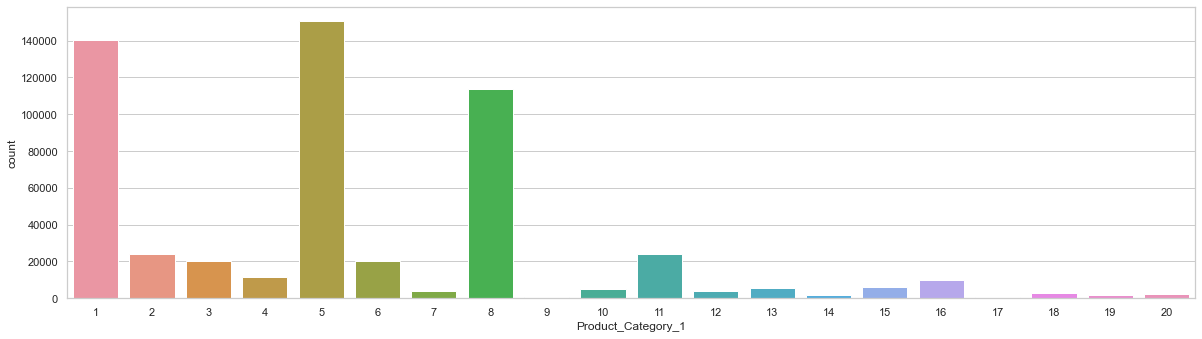

In [27]:
plt.figure(figsize=(18,5))
sns.countplot(train['Product_Category_1'])
plt.show()

Product_Category_1 numbers 1,5 and 8 stand out. Unfortunately we don't know which product each number represents as it is masked.

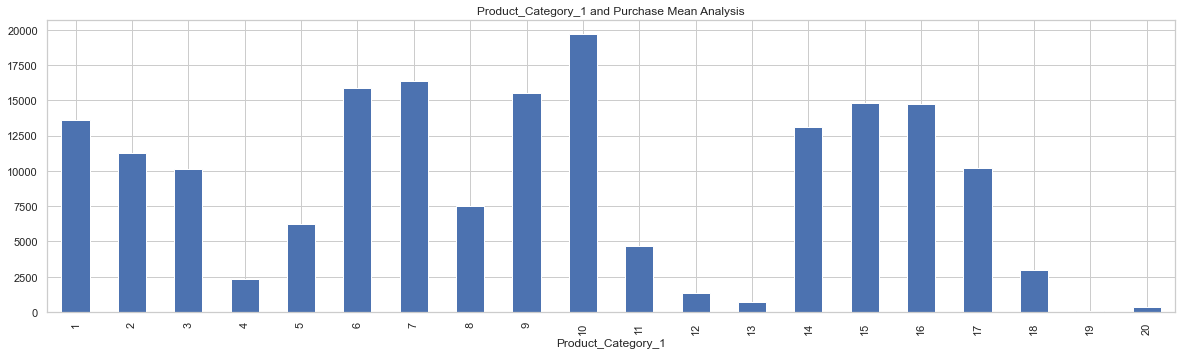

In [28]:
train.groupby('Product_Category_1').mean()['Purchase'].plot(kind='bar',figsize=(18,5))
plt.title("Product_Category_1 and Purchase Mean Analysis")
plt.show()

### City

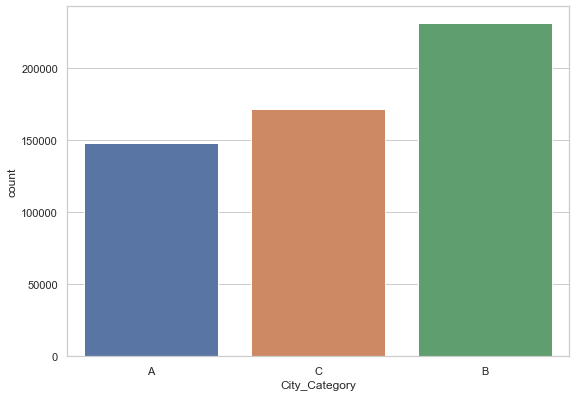

In [29]:
plt.figure(figsize=(8,6))
sns.countplot(x ='City_Category', data = train)
plt.show()

**Findings** : City B has made the most number of purchases followed by C

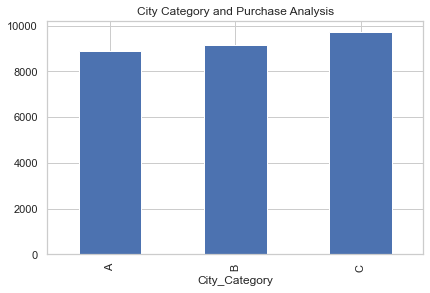

In [30]:
train.groupby("City_Category").mean()["Purchase"].plot(kind='bar')
plt.title("City Category and Purchase Analysis")
plt.show()

**Findings** : Eventhough people from City B purchases the most, City C spends the most amount. 

### Staying in City (Years)

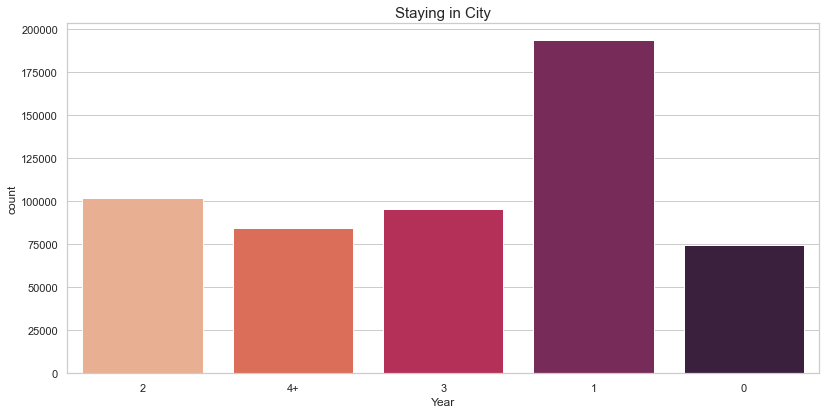

In [31]:
plt.figure(figsize=(12,6))
sns.countplot(train['Stay_In_Current_City_Years'],palette='rocket_r')
plt.title('Staying in City', size=15)
plt.xlabel('Year')
plt.show()

**Findings** : People who live in that city for a long time are less likely to buy new things. Newcomers to a city who need a great deal of new items for their house will therefore take advantage of the low prices on Black Friday in order to buy what they need.

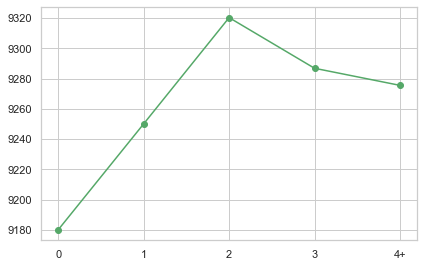

In [32]:
# Avearge amount spend based on the time of stay in the current city

data2 = train.groupby('Stay_In_Current_City_Years')['Purchase'].mean()
plt.plot(data2.index,data2.values,marker='o',color='g')
plt.show()

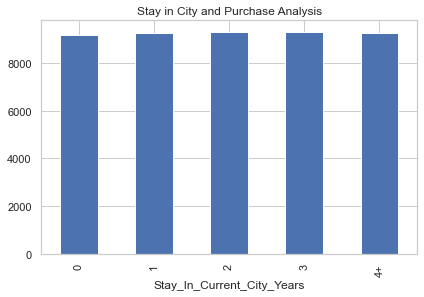

In [33]:
train.groupby("Stay_In_Current_City_Years").mean()["Purchase"].plot(kind='bar')
plt.title("Stay in City and Purchase Analysis")
plt.show()

**Findings** : Newcomers to the city are in charge of the greater number of purchases, but when it comes to individual purchases, they tend to spend the same amount regardless of how long they have lived in their current location.

### Age

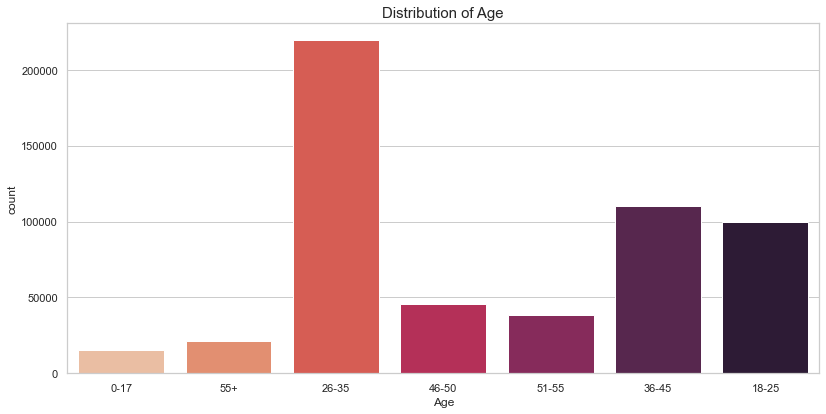

In [34]:
plt.figure(figsize=(12,6))
sns.countplot(train['Age'],palette='rocket_r')
plt.title('Distribution of Age', size=15)
plt.xlabel('Age')
plt.show()

**Finding** : People between age (26-35) group makes the most no of purchases in the age group.

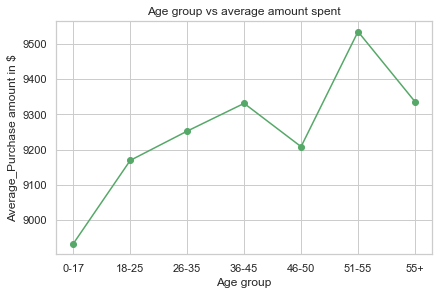

In [35]:
# Avearge amount spend by different age groups

data1 = train.groupby('Age')['Purchase'].mean()
plt.plot(data1.index,data1.values,marker='o',color='g')
plt.xlabel('Age group');
plt.ylabel('Average_Purchase amount in $');
plt.title('Age group vs average amount spent');
plt.show()

**Findings** : The average amount spend by age group 51-55 is most during the festive season sales.

### Data Preprocessing

In [36]:
data.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase,Product_Category_2,Type of data
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370.0,13.0,Train
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200.0,6.0,Train
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422.0,4.0,Train
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057.0,14.0,Train
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969.0,15.0,Train
5,1000003,P00193542,M,26-35,15,A,3,0,1,15227.0,2.0,Train
6,1000004,P00184942,M,46-50,7,B,2,1,1,19215.0,8.0,Train
7,1000004,P00346142,M,46-50,7,B,2,1,1,15854.0,15.0,Train
8,1000004,P0097242,M,46-50,7,B,2,1,1,15686.0,16.0,Train
9,1000005,P00274942,M,26-35,20,A,1,1,8,7871.0,11.0,Train


In [37]:
# User_ID data preprocess. e.g. 1000002 -> 2

data['User_ID'] = data['User_ID'] - 1000000

# Product_ID preprocess e.g. P00069042 -> 69042

data['Product_ID'] = data['Product_ID'].str.replace('P00', '')

#object to int
data['Product_ID'] = pd.to_numeric(data['Product_ID'],errors='coerce')

Datatype conversion for model enhancment

In [38]:
#Product Category 2
data.Product_Category_2 = data.Product_Category_2.astype('int64')

#Gender
data['Gender'] = data['Gender'].map({'F':0, 'M':1}).astype(int)

In [39]:
# Modify age column

data['Age'] = data['Age'].map({'0-17': 9,
                               '18-25': 22,
                               '26-35': 31,
                               '36-45': 42,
                               '46-50': 48,
                               '51-55': 53,
                               '55+': 60})
data['Age'].value_counts()

31    313015
42    156724
22    141953
48     65278
53     54784
60     30579
9      21334
Name: Age, dtype: int64

In [40]:
# 4+ to 4
data['Stay_In_Current_City_Years'] =np.where(data['Stay_In_Current_City_Years'].str[:2]=="4+",4,data['Stay_In_Current_City_Years'])

#object to int
data['Stay_In_Current_City_Years'] = pd.to_numeric(data['Stay_In_Current_City_Years'],errors='coerce')

In [41]:
data['City_Category']=data['City_Category'].map({"B":1,"A":2,"C":3})
data['City_Category']=data['City_Category'].astype(int)

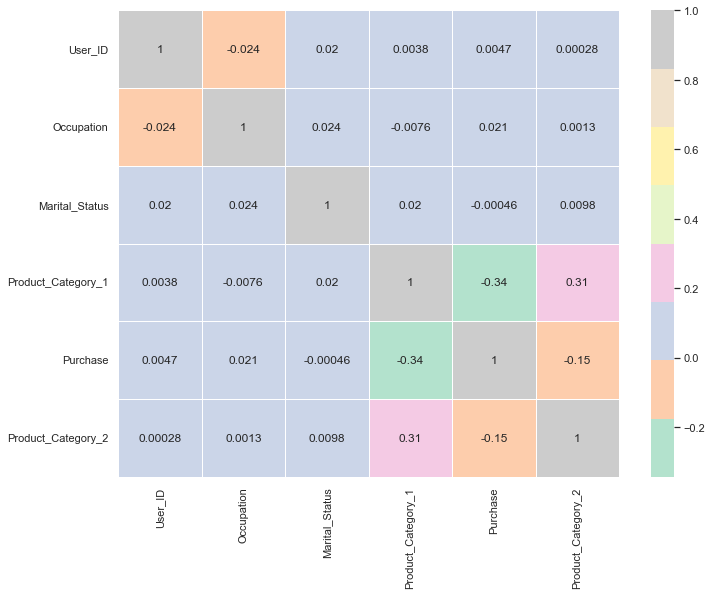

In [42]:
corrmat = train.corr()
corr_features = corrmat.index
plt.figure(figsize=(10,8))
g=sns.heatmap(train[corr_features].corr(),annot=True, linewidth =.9 , cmap="Pastel2")

In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     233599 non-null  int64  
 1   Product_ID                  233599 non-null  object 
 2   Gender                      233599 non-null  object 
 3   Age                         233599 non-null  object 
 4   Occupation                  233599 non-null  int64  
 5   City_Category               233599 non-null  object 
 6   Stay_In_Current_City_Years  233599 non-null  object 
 7   Marital_Status              233599 non-null  int64  
 8   Product_Category_1          233599 non-null  int64  
 9   Purchase                    0 non-null       float64
 10  Product_Category_2          161255 non-null  float64
 11  Product_Category_3          71037 non-null   float64
 12  Type of data                233599 non-null  object 
dtypes: float64(3),

### Model Building

In [44]:
output = pd.DataFrame()

output['User_ID'] = test['User_ID']
output['Product_ID'] = test['Product_ID']
output['Purchase'] = np.nan

In [45]:
#splitting the data back into train and test as it was already provided

train = data[data['Type of data']=='Train']
del train['Type of data']
test = data[data['Type of data']=='Test']
test.drop(['Purchase','Type of data'],axis=1,inplace=True)

del data

In [46]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase,Product_Category_2
0,1,69042,0,9,10,2,2,0,3,8370.0,13
1,1,248942,0,9,10,2,2,0,1,15200.0,6
2,1,87842,0,9,10,2,2,0,12,1422.0,4
3,1,85442,0,9,10,2,2,0,12,1057.0,14
4,2,285442,1,60,16,3,4,0,8,7969.0,15


In [47]:
#splitting the data into X and y
X = train.drop('Purchase',axis=1)
y = train['Purchase']

#train test split for model building
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=0)

### 1) Linear Regression

In [48]:
#Linear regression

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train) # training the algorithm

# Getting the coefficients and intercept

print('coefficients:\n', lr.coef_)
print('\n intercept:', lr.intercept_)

coefficients:
 [ 1.78828617e-02 -3.70348839e-03  5.30571111e+02  1.65100509e+01
  7.36048211e+00  2.40556332e+02  1.63762755e+01 -5.71191660e+01
 -4.11783673e+02 -4.69918703e+01]

 intercept: 11042.816353625787


In [49]:
#Predicting on the test data

y_pred = lr.predict(X_test)

from sklearn import metrics

print('r2_score:', metrics.r2_score(y_test,y_pred)) 
print('rmse:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

r2_score: 0.13052224771751864
rmse: 4689.610487166007


### 2) Decision Tree Model

In [50]:
# Decision Tree Model

from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)

DT.fit(X_train, y_train)

y_pred = DT.predict(X_test)

print('rmse:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

rmse: 2739.0579311299994


In [51]:
DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)

DT.fit(X,y)

predict = DT.predict(test)

output['Purchase'] = predict
output.to_csv('Sample_Submission_DT.csv',index=False)



### 3) Random Forest Regressor

In [52]:
#Fitting the model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 3,max_depth=10,n_estimators=25)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

print('r2_score:', metrics.r2_score(y_test,y_pred)) 
print('rmse:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

r2_score: 0.691196452578995
rmse: 2794.786750228736


In [53]:
#Random Forest model

rf = RandomForestRegressor(random_state = 3,max_depth=10,n_estimators=25)
rf.fit(X,y)
predict = rf.predict(test)

output['Purchase'] = predict

output.to_csv('Sample_Submission_rf.csv',index=False)



### 4) XG Boost

In [54]:
## XGBoost2
from xgboost import XGBRegressor

xgb2 = XGBRegressor(n_estimators=500,max_depth=10,learning_rate=0.05)

xgb2.fit(X_train,y_train)

y_pred = xgb2.predict(X_test)

print('r2_score:', metrics.r2_score(y_test,y_pred)) 
print('rmse:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

r2_score: 0.7488792937061037
rmse: 2520.2800251681333


In [55]:
xgb2 = XGBRegressor(n_estimators=500,max_depth=10,learning_rate=0.05)

xgb2.fit(X,y)
predict = xgb2.predict(test)

output['Purchase'] = predict

output.to_csv('Sample_XGB2.csv')



## Conclusion

A range of algorithms was used in this project, including linear regression, decision tree regression, random forest, and XGB regression, in order to make the most accurate prediction possible.

In this problem, the hyperparameter tuned **XGB regressor** gives us the best rmse value and r2 score.

Parameters and score: 

XGBRegressor(n_estimators=500,max_depth=10,learning_rate=0.05)

- r2_score: 0.7488792937061037

- rmse: 2520.2800251681333

In [56]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(10)
df2= df.head(600)
df1.head(5)

,Actual,Predicted
41001,15228.0,14013.183594
16151,1088.0,976.628052
507262,16426.0,17505.673828
368698,12042.0,17831.884766
353782,8699.0,7573.089844


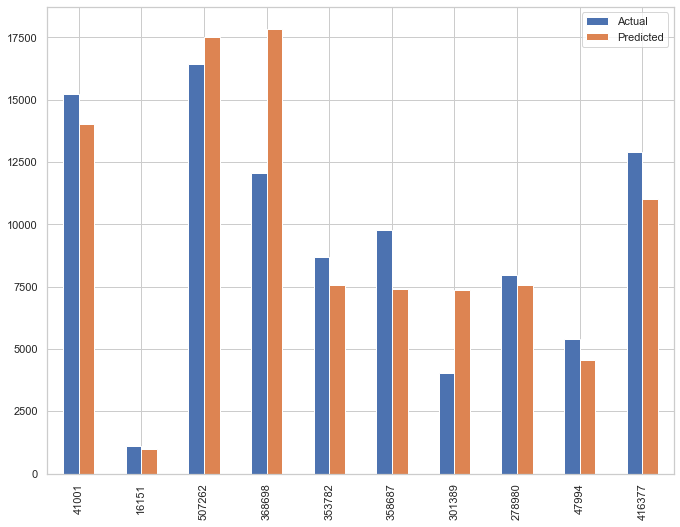

In [57]:
df1.plot(kind='bar',figsize=(10,8))
plt.show()

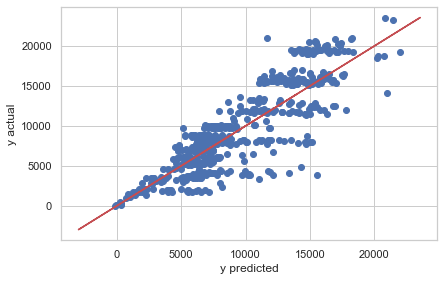

In [58]:
plt.scatter(df2.Predicted,df2.Actual)
plt.plot(y_pred,y_pred,'r')
plt.xlabel('y predicted')
plt.ylabel('y actual')
plt.show()